# Data Augmentation with Generative Networks for Medical Imaging


<img src="img/GAN1.png">



This lab demonstrates to use Generative Adversarial Networks (GANs) for  generating randomized brain MRI images from random noise using a GAN. 

## Background
Generative Adversarial Networks (GAN) were first introduced by Ian Goodfellow et al, in 2014 (https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).

It was shown that random handwritten digits could be generated from the generator network of a GAN, after training on the MNIST dataset (http://yann.lecun.com/exdb/mnist/).

### Preparation
We first need to load some libraries and perform a few final data preparation steps. You can read on in the notebook while these steps are running.

In [1]:
# import necessary packages
import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
matplotlib.use('Agg')
%matplotlib inline
import PIL
import imageio
import random
import SimpleITK as sitk
from IPython import display
from IPython.display import Image
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
tf.enable_eager_execution()


## 1. Data Exploration

In [2]:
dataDir = 'data/brainmri/'
files = glob.glob(os.path.join(dataDir, '*.png'))
print('Total number of images in the dataset', len(files))

Total number of images in the dataset 34160


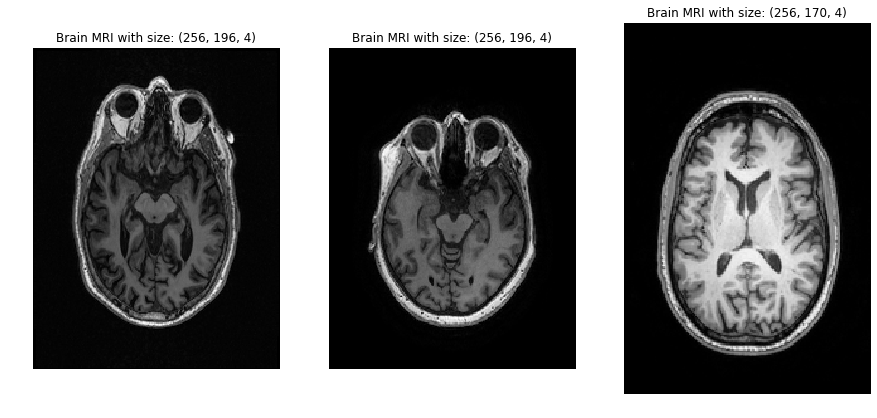

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
i = 0
for ax in axes:
    idx = np.random.randint(0, len(files))
    filename = files[idx]
    img = mpimg.imread(filename)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title('Brain MRI with size: {}'.format(img.shape))
    i += 1

* As we can see there is not a consistent size in the images, we need to consider this in the image processing step. 

## 2. Data Processing
Lets create a function to solve the size consitency problem:

In [4]:
# read images and provide a consitent size of 64 by 64 pixels
def _parse_function(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=1)
    image_resized = tf.image.resize_images(image_decoded, [64, 64])
    return image_resized

* Now let's normalize the pixels values in the image, instead of using pixels from 0 to 255 we can get values in the range of [-0.5 to 0.5], this will help the neural network to avoid getting stuck in local minima and would help the the algorithm converve faster:

In [5]:
# normalize images
def _train_preprocess(image):
    image = (image - 127.5) / 127.5
    return image

* Finally let's shufflee the data and apply the preprocessing functions to the MRIs

In [6]:
random.shuffle(files)
dataset = tf.data.Dataset.from_tensor_slices((files))
dataset = dataset.shuffle(10000)
dataset = dataset.map(_parse_function, num_parallel_calls=16)
dataset = dataset.map(_train_preprocess, num_parallel_calls=16)

In [7]:
dataset = dataset.batch(256).prefetch(256 * 4)

## 3. Algorithm creation

* Lets begin remembering how GANs work: 


The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='img/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data (instead we are using brain MRIs). The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

Once the generator has trained, we can throw out the discriminator after we are done with training. 

In [8]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

In [9]:
# create generator class
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = tf.keras.layers.Dense(8*8*64, use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()

        self.conv1 = tf.keras.layers.Conv2DTranspose(64 * 8, (4, 4), strides=(1, 1), padding='same', use_bias=False)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2DTranspose(64 * 4, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2DTranspose(64 * 2, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm4 = tf.keras.layers.BatchNormalization()

        self.conv4 = tf.keras.layers.Conv2DTranspose(64 * 1, (4, 4), strides=(2, 2), padding='same', use_bias=False)
        self.batchnorm5 = tf.keras.layers.BatchNormalization()

        self.conv5 = tf.keras.layers.Conv2DTranspose(1, (4, 4), strides=(1, 1), padding='same', use_bias=False)

    def call(self, x, training=True):
        x = self.fc1(x)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.relu(x)

        x = tf.reshape(x, shape=(-1, 8, 8, 64))

        x = self.conv1(x)
        x = self.batchnorm2(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.batchnorm3(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.batchnorm4(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv4(x)
        x = self.batchnorm5(x, training=training)
        x = tf.nn.relu(x)

        x = tf.nn.tanh(self.conv5(x))  
        return x


In [10]:
# create discriminator class
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64 * 2, (4, 4), strides=(2, 2), padding='same')
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(64 * 4, (4, 4), strides=(2, 2), padding='same')
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.conv4 = tf.keras.layers.Conv2D(64 * 8, (4, 4), strides=(2, 2), padding='same')
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        self.conv5 = tf.keras.layers.Conv2D(1, (4, 4), strides=(1, 1), padding='valid')

        self.dropout = tf.keras.layers.Dropout(0.3)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)

    def call(self, x, training=True):
        x = tf.nn.leaky_relu(self.conv1(x))

        x = self.conv2(x)
        x = self.batchnorm2(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv3(x)
        x = self.batchnorm3(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv4(x)
        x = self.batchnorm4(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv5(x)
        x = self.fc1(x)
        return x


In [11]:
generator = Generator()
discriminator = Discriminator()

In [12]:
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

discriminator_optimizer = tf.train.AdamOptimizer(1e-4)
generator_optimizer = tf.train.AdamOptimizer(1e-4)

Once that the discriminator and generator classes are created let's set the losses for their respective losses:
<img src='img/gan_dis.png'>

In [13]:
# loss function discriminator  
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)
    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
    total_loss = real_loss + generated_loss
    return total_loss

# loss function discriminator generator
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

* An auxiliar function to create and save the output images of the generator

In [14]:
def generate_and_save_images(model, epoch, test_input, imsave_dir):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()
    plt.savefig(os.path.join(imsave_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()


* Before begining we are going to tune some hyperparameters for the GAN and enable eager execturion for tensorflow:

In [17]:
BATCH_SIZE = 1
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

We will first train a GAN to generate random 2-dimensional T1-weighted brain MRIs, the T1-weighted brain MRIs will be generated from random noise, shown as "z", we train the Generator and Discriminator concurrently. The Discriminator is trained to distinguish "real" and "generated" brain MRIs, and the Generator is trained to win over the Discrimiator, i.e., generate more realistic brain MRI so that the Discriminator cannot distinguish them from real brain MRIs.


In [ ]:
#tfe = tf.contrib.eager
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

for epoch in range(EPOCHS):
    start = time.time()
    
    for images in dataset:
        noise = tf.random_normal([BATCH_SIZE, noise_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            
            real_output = discriminator(images, training=True)
            generated_output = discriminator(generated_images, training=True)
            
            gen_loss = generator_loss(generated_output)
            disc_loss = discriminator_loss(real_output, generated_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
      
    if epoch % 1 == 0:
        #display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation, imsave_dir)

    # saving (checkpoint) the model every 15 epochs
    if epoch % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    # generating after the final epoch
    generate_and_save_images(generator,
                               epochs,
                               random_vector_for_generation, imsave_dir)
